In [1]:
import os
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')


import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
from PcmPy.tmp__inference_cka import fit_CKA_individ
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Identity simulation

## Build data

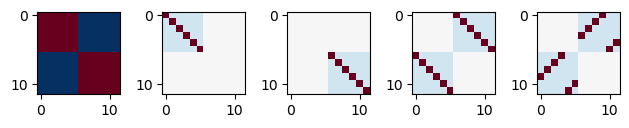

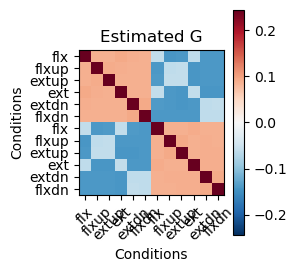

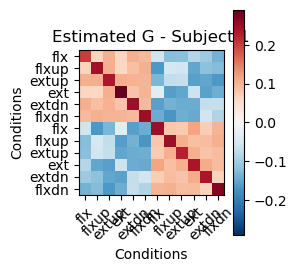

In [2]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
nsim = 500
signal = [0.5]*nsim
ncond = 12
num_items = 6
# rng = np.random.default_rng(seed=3)

G_model = {}

# hand component:
cov = np.zeros((ncond, ncond))
cov[0:6,0:6] = 1
cov[6:12,6:12] = 1
cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
cov = cov / np.trace(cov)
G_model['hand'] = cov

# contra hand:
C = pcm.centering(num_items) @ np.eye(num_items)/num_items @ pcm.centering(num_items)
cov = np.zeros((ncond, ncond))
cov[0:6,0:6] = C
G_model['contra'] = cov

# ipsi hand:
cov = np.zeros((ncond, ncond))
cov[6:12,6:12] = C
G_model['ipsi'] = cov

# intrinsic:
cov = np.zeros((ncond, ncond))
cov[0:6,6:12] = C
cov[6:12,0:6] = C.T
G_model['intrinsic'] = cov

# extrinsic:
cov = np.zeros((ncond, ncond))
C_ext = np.zeros((6,6)) # picking the extrinsicly similar conditions (moving to the same direction in space): e.g., flxup:extup, extdn:flxdn, ...
C_ext[0,3] = 1
C_ext[3,0] = 1
C_ext[1,2] = 1
C_ext[2,1] = 1
C_ext[4,5] = 1
C_ext[5,4] = 1
C_ext = pcm.centering(num_items) @ C_ext/num_items @ pcm.centering(num_items)
cov[0:6,6:12] = C_ext
cov[6:12,0:6] = C_ext.T
G_model['extrinsic'] = cov

Mtrue = pcm.ComponentModel('trueG', [G_model['hand'], G_model['contra'], G_model['ipsi'], G_model['intrinsic'], G_model['extrinsic']])
theta_true = np.array([1,0.6,0.6,0,0])

# visualize the true G:
H = Mtrue.n_param
for i in range(H):
    plt.subplot(1, H, i+1)
    vmin = -np.max(np.abs(Mtrue.Gc[i,:,:]))
    vmax = np.max(np.abs(Mtrue.Gc[i,:,:]))
    plt.imshow(Mtrue.Gc[i,:,:], vmin=vmin, vmax=vmax, cmap='RdBu_r')
plt.tight_layout()
plt.show()

cond_vec, part_vec = pcm.sim.make_design(n_cond=12, n_part=10)
D = pcm.sim.make_dataset(model=Mtrue, \
    theta=theta_true,
    cond_vec=cond_vec,
    part_vec=part_vec,
    n_sim=nsim,
    n_channel=300,
    signal=signal)

# data g matrix:
N = len(D)
G_hat = np.zeros((N, ncond, ncond))
Dist = np.zeros((N,ncond,ncond))
for i in range(N):
    G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                            D[i].obs_descriptors['cond_vec'],
                                            D[i].obs_descriptors['part_vec'],
                                            X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))
    Dist[i,:,:] = pcm.G_to_dist(G_hat[i,:,:])

# visualize the estimated G:
G_mean = np.mean(G_hat, axis=0)
plt.figure(figsize=(3,3))
vmin = -np.max(np.abs(G_mean))
vmax = np.max(np.abs(G_mean))
plt.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Estimated G')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()

# visualize subject 1:
G_subj = G_hat[0,:,:]
plt.figure(figsize=(3,3))
vmin = -np.max(np.abs(G_subj))
vmax = np.max(np.abs(G_subj))
plt.imshow(G_subj, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Estimated G - Subject 1')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()



## Fit model

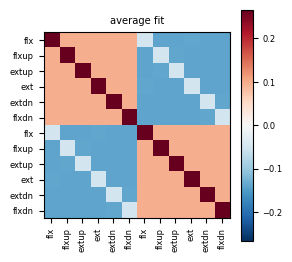

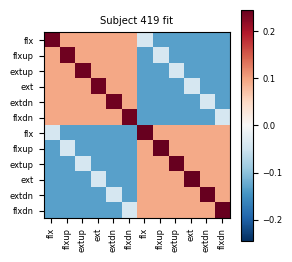

/var/folders/sc/kmc7_9gn2hqd_lrnhdt_2s580000gn/T/ipykernel_27049/3815714505.py:48: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  T.stack(level='model')        # move model into the index
/var/folders/sc/kmc7_9gn2hqd_lrnhdt_2s580000gn/T/ipykernel_27049/3815714505.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T_cka['value'] = np.arctanh(T_cka['value'])  # Fisher z-transform


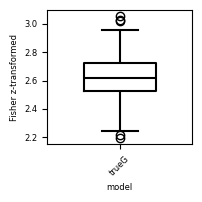

[  1.          -0.10346145  -0.10237533  -1.76766707 -15.2303891 ]


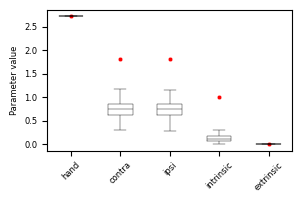

In [12]:
M = [Mtrue]

T, theta = fit_CKA_individ(D, M, fixed_effect='block', theta0=None, verbose = False)
# print(theta)

nmodels = len(M)
# set font:
matplotlib.rcParams.update({'font.size': 6})
# Plot model predictions:
fig, ax = plt.subplots(1, figsize=(3,3))
G_pred = np.zeros((nsim, ncond, ncond))
for i in range(nsim):
    th = theta[0][:,i]
    G_pred[i,:,:] = M[0].predict(th[:M[0].n_param])[0]

G_mean = np.mean(G_pred, axis=0)
vmin = -np.max(np.abs(G_mean))
vmax = np.max(np.abs(G_mean))
ax.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax.set_xticks(list(range(12)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(list(range(12)))
ax.set_yticklabels(labels)
ax.set_title('average fit')
plt.colorbar(ax.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax)
plt.show()

# model fit for a subject:
# Plot model predictions:
fig, ax = plt.subplots(1, figsize=(3,3))
# th = np.mean(theta[i], axis=1)
n = np.random.randint(0, nsim)
G = G_pred[n,:,:]
vmin = -np.max(np.abs(G))
vmax = np.max(np.abs(G))
ax.imshow(G, cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax.set_xticks(list(range(12)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(list(range(12)))
ax.set_yticklabels(labels)
ax.set_title(f'Subject {n} fit')
plt.colorbar(ax.imshow(G, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax)
plt.show()

# Convert MultiIndex columns to long form
# Stack the *model* level, so models become rows
T_long = (
    T.stack(level='model')        # move model into the index
      .reset_index()              # index -> columns
      .melt(id_vars=['level_0', 'model'],
            var_name='metric',
            value_name='value')
)
T_long

# boxplot CKA:
T_cka = T_long[T_long['metric'] == 'CKA']
T_cka['value'] = np.arctanh(T_cka['value'])  # Fisher z-transform
plt.figure(figsize=(2,2))
sns.boxplot(data=T_cka, x='model', y='value', color='k', fill=False, width=0.5)
plt.xticks(rotation=45)
plt.ylabel('Fisher z-transformed')
plt.tight_layout()
plt.show()

th = np.mean(theta[0],axis=1)
print(th/th[0])

# boxplot of parameters across subject:
th = theta[0]/theta[0][0,:]
fig, ax = plt.subplots(1, figsize=(3,2))
sns.boxplot(data=pd.DataFrame(np.exp(th.T), columns=['hand', 'contra', 'ipsi', 'intrinsic', 'extrinsic']), ax=ax, color='k', fill=False, width=0.5, linewidth=0.3, showfliers=False)
# ground truth:
sns.scatterplot(x=['hand', 'contra', 'ipsi', 'intrinsic', 'extrinsic'], y=np.exp(theta_true), color='red', s=10, ax=ax, label='')
plt.xticks(rotation=45)
plt.ylabel('Parameter value')
plt.tight_layout()
plt.show()




# Data simulation

## Build data

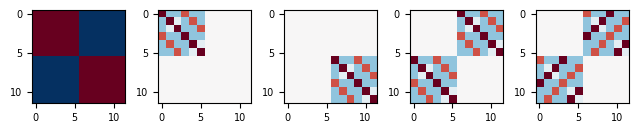

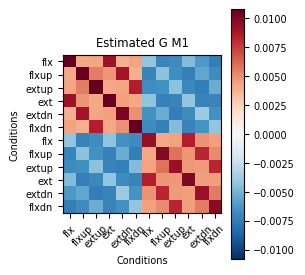

MEAN DIAG: 0.010110272932522814


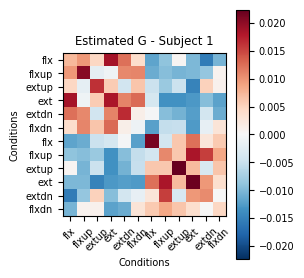

In [ ]:
region = 'M1'
file_path = os.path.join(analysisDir, f'pcm_Ghat_best_within_model_{region}.npz')
data = np.load(file_path)
G_mdl = data['G_hat']
G_mdl = G_mdl / np.trace(G_mdl)

labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
nsim = 500
signal = [0.01]*nsim
ncond = 12
num_items = 6
# rng = np.random.default_rng(seed=3)

G_model = {}

# hand component:
cov = np.zeros((ncond, ncond))
cov[0:6,0:6] = 1
cov[6:12,6:12] = 1
cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
cov = cov / np.trace(cov)
G_model['hand'] = cov

# contra hand:
C = G_mdl
cov = np.zeros((ncond, ncond))
cov[0:6,0:6] = C
G_model['contra'] = cov

# ipsi hand:
cov = np.zeros((ncond, ncond))
cov[6:12,6:12] = C
G_model['ipsi'] = cov

# intrinsic:
cov = np.zeros((ncond, ncond))
cov[0:6,6:12] = C
cov[6:12,0:6] = C.T
G_model['intrinsic'] = cov

# extrinsic:
cov = np.zeros((ncond, ncond))
C_ext = C[:, [3,2,1,0,5,4]]
cov[0:6,6:12] = C_ext
cov[6:12,0:6] = C_ext.T
G_model['extrinsic'] = cov

Mtrue = pcm.ComponentModel('trueG', [G_model['hand'], G_model['contra'], G_model['ipsi'], G_model['intrinsic'], G_model['extrinsic']])
theta_true = np.array([2,1,0.8,0.2,-10e10])
# theta_true = np.array([-10e20,-10e2,-10e20,-10e20,-10e20])


# visualize the true G:
H = Mtrue.n_param
for i in range(H):
    plt.subplot(1, H, i+1)
    vmin = -np.max(np.abs(Mtrue.Gc[i,:,:]))
    vmax = np.max(np.abs(Mtrue.Gc[i,:,:]))
    plt.imshow(Mtrue.Gc[i,:,:], vmin=vmin, vmax=vmax, cmap='RdBu_r')
plt.tight_layout()
plt.show()

cond_vec, part_vec = pcm.sim.make_design(n_cond=12, n_part=10)
D = pcm.sim.make_dataset(model=Mtrue, \
    theta=theta_true,
    cond_vec=cond_vec,
    part_vec=part_vec,
    n_sim=nsim,
    n_channel=300,
    signal=signal)

# data g matrix:
N = len(D)
G_hat = np.zeros((N, ncond, ncond))
Dist = np.zeros((N,ncond,ncond))
for i in range(N):
    G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                            D[i].obs_descriptors['cond_vec'],
                                            D[i].obs_descriptors['part_vec'],
                                            X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))
    Dist[i,:,:] = pcm.G_to_dist(G_hat[i,:,:])

plt.rcParams.update({'font.size': 7})
# visualize the estimated G:
G_mean = np.mean(G_hat, axis=0)
plt.figure(figsize=(3,3))
vmin = -np.max(np.abs(G_mean))
vmax = np.max(np.abs(G_mean))
plt.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f'Estimated G {region}')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()

print(f'MEAN DIAG: {np.mean(np.diag(G_mean))}')

# visualize subject 1:
G_subj = G_hat[0,:,:]
plt.figure(figsize=(3,3))
vmin = -np.max(np.abs(G_subj))
vmax = np.max(np.abs(G_subj))
plt.imshow(G_subj, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Estimated G - Subject 1')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()



## Fit models

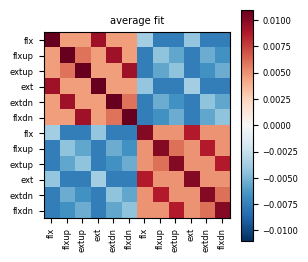

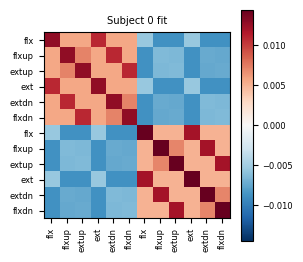

/var/folders/sc/kmc7_9gn2hqd_lrnhdt_2s580000gn/T/ipykernel_54129/402335651.py:48: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  T.stack(level='model')        # move model into the index


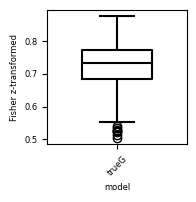

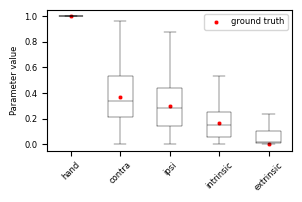

In [23]:
M = [Mtrue]

T, theta = fit_CKA_individ(D, M, fixed_effect='block', theta0=None, verbose = False)
# print(theta)

nmodels = len(M)
# set font:
matplotlib.rcParams.update({'font.size': 6})
# Plot model predictions:
fig, ax = plt.subplots(1, figsize=(3,3))
G_pred = np.zeros((nsim, ncond, ncond))
for i in range(nsim):
    th = theta[0][:,i]
    G_pred[i,:,:] = M[0].predict(th[:M[0].n_param])[0]

G_mean = np.mean(G_pred, axis=0)
vmin = -np.max(np.abs(G_mean))
vmax = np.max(np.abs(G_mean))
ax.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax.set_xticks(list(range(12)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(list(range(12)))
ax.set_yticklabels(labels)
ax.set_title('average fit')
plt.colorbar(ax.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax)
plt.show()

# model fit for a subject:
# Plot model predictions:
fig, ax = plt.subplots(1, figsize=(3,3))
# th = np.mean(theta[i], axis=1)
n = np.random.randint(0, nsim)
G = G_pred[n,:,:]
vmin = -np.max(np.abs(G))
vmax = np.max(np.abs(G))
ax.imshow(G, cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax.set_xticks(list(range(12)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(list(range(12)))
ax.set_yticklabels(labels)
ax.set_title(f'Subject {n} fit')
plt.colorbar(ax.imshow(G, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax)
plt.show()

# Convert MultiIndex columns to long form
# Stack the *model* level, so models become rows
T_long = (
    T.stack(level='model')        # move model into the index
      .reset_index()              # index -> columns
      .melt(id_vars=['level_0', 'model'],
            var_name='metric',
            value_name='value')
)
T_long

# boxplot CKA:
T_cka = T_long[T_long['metric'] == 'CKA']
# T_cka['value'] = np.arctanh(T_cka['value'])  # Fisher z-transform
plt.figure(figsize=(2,2))
sns.boxplot(data=T_cka, x='model', y='value', color='k', fill=False, width=0.5)
plt.xticks(rotation=45)
plt.ylabel('Fisher z-transformed')
plt.tight_layout()
plt.show()


th = np.exp(theta[0])
th = th/th[0,:]
# print(np.mean(th,axis=1))

# boxplot of parameters across subject:
fig, ax = plt.subplots(1, figsize=(3,2))
sns.boxplot(data=pd.DataFrame(th.T, columns=['hand', 'contra', 'ipsi', 'intrinsic', 'extrinsic']), ax=ax, color='k', fill=False, width=0.5, linewidth=0.3, showfliers=False)
# ground truth: 
sns.scatterplot(x=['hand', 'contra', 'ipsi', 'intrinsic', 'extrinsic'], y=np.exp(theta_true)/np.exp(theta_true)[0], color='red', s=10, ax=ax, label='ground truth')
plt.xticks(rotation=45)
plt.ylabel('Parameter value')
plt.tight_layout()
plt.show()




## Intrinsic Pearson r

============== M1 ==============
Mean Fisher Z: 0.022 +/- 0.001
T-test != 0: t(499) = 17.549, p = 4.7564e-54


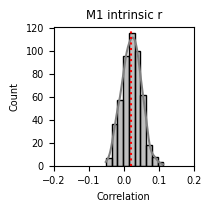

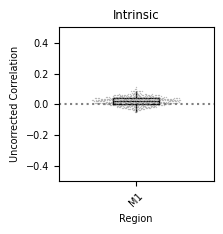

In [89]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'

df = {'region':[], 'r':[], 'fisher_Z':[]}

plt.rcParams.update({'font.size': 7})
fig, axes = plt.subplots(1, 1, figsize=(2,2), constrained_layout=True)
N = len(D)
r = []
fisher_Z = []
for i in range(N):
    measurements = D[i].measurements
    cond_vec = np.array([0,1,2,3,4,5,6,7,8,9,10,11]*10)
    num_voxels = measurements.shape[1]
    ncond = 12

    # Create an array to store the averaged patterns for each condition
    averaged_patterns = np.zeros((ncond, num_voxels))

    # Loop through each condition and calculate the average pattern
    for c in range(ncond):
        # Find rows corresponding to the current condition
        condition_indices = cond_vec == c
        # Calculate the mean pattern for the current condition
        averaged_patterns[c, :] = measurements[condition_indices, :].mean(axis=0)

    # get the contra conditions: 
    y_contra_avg = averaged_patterns[0:6, :]
    # remove mean across conditions:
    y_contra_avg = y_contra_avg - y_contra_avg.mean(axis=0)
    # flatten the averaged patterns:
    y_contra_vec = y_contra_avg.flatten()
    
    # get the ipsi conditions:
    y_ipsi_avg = averaged_patterns[6:12, :]
    # remove mean across conditions:
    y_ipsi_avg = y_ipsi_avg - y_ipsi_avg.mean(axis=0)
    # flatten the averaged patterns:
    y_ipsi_vec = y_ipsi_avg.flatten()

    # concatenate the contra and ipsi patterns:
    r.append(np.corrcoef(y_contra_vec, y_ipsi_vec)[0,1])
    fisher_Z.append(np.arctanh(r[-1]))

r = np.array(r)
fisher_Z = np.array(fisher_Z)
df['region'].extend([region] * len(r))
df['r'].extend(r)
df['fisher_Z'].extend(fisher_Z)
print(f'============== {region} ==============')
print(f'Mean Fisher Z: {np.mean(fisher_Z):.3f} +/- {stats.sem(fisher_Z):.3f}')

# t-test > 0:
t_stat, p_val = stats.ttest_1samp(fisher_Z, 0, alternative='two-sided')
print(f'T-test != 0: t({N-1}) = {t_stat:.3f}, p = {p_val:.4e}')

# distribution of r:
ax = axes
sns.histplot(fisher_Z, kde=True, color='gray', ax=ax, bins=10)
ax.axvline(np.mean(fisher_Z), color='red', linestyle=':')
ax.set_xlabel('Correlation')
ax.set_ylabel('Count')
ax.set_title(f'{region} intrinsic r')
ax.set_xlim(-0.2,0.2)
plt.show()

df = pd.DataFrame(df)
# boxplot:
plt.figure(figsize=(2,2))
plt.axhline(0, color='gray', linestyle=':')
sns.swarmplot(x='region', y='r', data=df, color='gray', size=1, alpha=0.5)
sns.boxplot(x='region', y='r', data=df, width=0.3, color='k', fill=False, showcaps=False, linewidth=1, fliersize=0)
plt.xlabel('Region')
plt.ylabel('Uncorrected Correlation')
plt.title('Intrinsic')
plt.ylim(-0.5,0.5)
# rotate x-tick labels:
plt.xticks(rotation=45)
plt.show()




## Extrinsic Pearson r

============== M1 ==============
Mean Fisher Z: 0.028 +/- 0.001
T-test != 0: t(499) = 23.349, p = 4.8552e-82


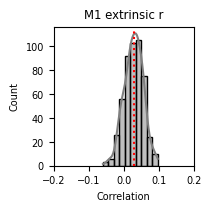

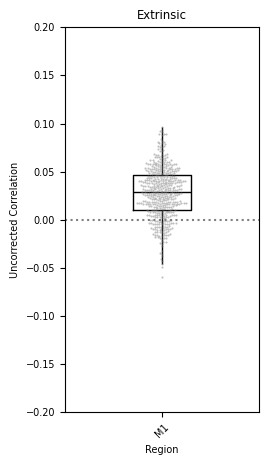

In [86]:
df = {'region':[], 'r':[], 'fisher_Z':[]}

fig, axes = plt.subplots(1, 1, figsize=(2,2), constrained_layout=True)
N = len(D)
r = []
fisher_Z = []
for i in range(N):
    measurements = D[i].measurements
    cond_vec = np.array([3,2,1,0,5,4,6,7,8,9,10,11]*10)
    num_voxels = measurements.shape[1]
    ncond = 12

    # Create an array to store the averaged patterns for each condition
    averaged_patterns = np.zeros((ncond, num_voxels))

    # Loop through each condition and calculate the average pattern
    for c in range(ncond):
        # Find rows corresponding to the current condition
        condition_indices = cond_vec == c
        # Calculate the mean pattern for the current condition
        averaged_patterns[c, :] = measurements[condition_indices, :].mean(axis=0)

    # get the contra conditions:
    y_contra_avg = averaged_patterns[0:6, :]
    # remove mean across conditions:
    y_contra_avg = y_contra_avg - y_contra_avg.mean(axis=0)
    # flatten the averaged patterns:
    y_contra_vec = y_contra_avg.flatten()
    
    # get the ipsi conditions:
    y_ipsi_avg = averaged_patterns[6:12, :]
    # remove mean across conditions:
    y_ipsi_avg = y_ipsi_avg - y_ipsi_avg.mean(axis=0)
    # flatten the averaged patterns:
    y_ipsi_vec = y_ipsi_avg.flatten()

    # concatenate the contra and ipsi patterns:
    r.append(np.corrcoef(y_contra_vec, y_ipsi_vec)[0,1])
    fisher_Z.append(np.arctanh(r[-1]))


r = np.array(r)
fisher_Z = np.array(fisher_Z)
df['region'].extend([region] * len(r))
df['r'].extend(r)
df['fisher_Z'].extend(fisher_Z)
print(f'============== {region} ==============')
print(f'Mean Fisher Z: {np.mean(fisher_Z):.3f} +/- {stats.sem(fisher_Z):.3f}')

# t-test > 0:
t_stat, p_val = stats.ttest_1samp(fisher_Z, 0, alternative='two-sided')
print(f'T-test != 0: t({N-1}) = {t_stat:.3f}, p = {p_val:.4e}')

# distribution of r:
ax = axes
sns.histplot(fisher_Z, kde=True, color='gray', ax=ax, bins=10)
ax.axvline(np.mean(fisher_Z), color='red', linestyle=':')
ax.set_xlabel('Correlation')
ax.set_ylabel('Count')
ax.set_title(f'{region} extrinsic r')
ax.set_xlim(-0.2,0.2)
plt.show()

# boxplot:
plt.figure(figsize=(2.5,5))
plt.axhline(0, color='gray', linestyle=':')
sns.swarmplot(x='region', y='r', data=df, color='gray', size=1.5, alpha=0.5)
sns.boxplot(x='region', y='r', data=df, width=0.3, color='k', fill=False, showcaps=False, linewidth=1, fliersize=0)
plt.xlabel('Region')
plt.ylabel('Uncorrected Correlation')
plt.title('Extrinsic')
plt.ylim(-0.2,0.2)
# rotate x-tick labels:
plt.xticks(rotation=45)
plt.show()



## Fit identity models

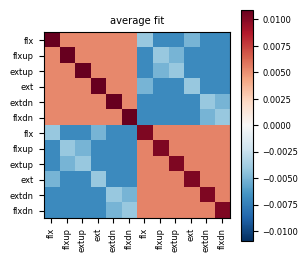

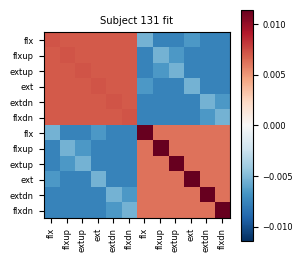

/var/folders/sc/kmc7_9gn2hqd_lrnhdt_2s580000gn/T/ipykernel_72061/3210989494.py:91: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  T.stack(level='model')        # move model into the index
/var/folders/sc/kmc7_9gn2hqd_lrnhdt_2s580000gn/T/ipykernel_72061/3210989494.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  T_cka['value'] = np.arctanh(T_cka['value'])  # Fisher z-transform


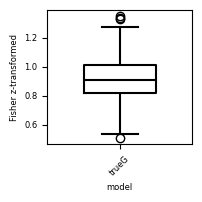

[1.         0.48252713 0.41162069 0.23853953 0.16169909]


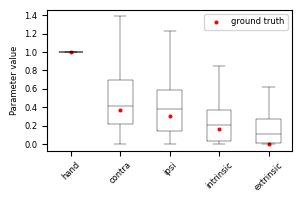

In [27]:
num_items = 6
G_model = {}

# hand component:
cov = np.zeros((ncond, ncond))
cov[0:6,0:6] = 1
cov[6:12,6:12] = 1
cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
cov = cov / np.trace(cov)
G_model['hand'] = cov

# contra hand:
C = pcm.centering(num_items) @ np.eye(num_items)/num_items @ pcm.centering(num_items)
cov = np.zeros((ncond, ncond))
cov[0:6,0:6] = C
G_model['contra'] = cov

# ipsi hand:
cov = np.zeros((ncond, ncond))
cov[6:12,6:12] = C
G_model['ipsi'] = cov

# intrinsic:
cov = np.zeros((ncond, ncond))
cov[0:6,6:12] = C
cov[6:12,0:6] = C.T
G_model['intrinsic'] = cov

# extrinsic:
cov = np.zeros((ncond, ncond))
C_ext = np.zeros((6,6)) # picking the extrinsicly similar conditions (moving to the same direction in space): e.g., flxup:extup, extdn:flxdn, ...
C_ext[0,3] = 1
C_ext[3,0] = 1
C_ext[1,2] = 1
C_ext[2,1] = 1
C_ext[4,5] = 1
C_ext[5,4] = 1
C_ext = pcm.centering(num_items) @ C_ext/num_items @ pcm.centering(num_items)
cov[0:6,6:12] = C_ext
cov[6:12,0:6] = C_ext.T
G_model['extrinsic'] = cov

Midentity = pcm.ComponentModel('trueG', [G_model['hand'], G_model['contra'], G_model['ipsi'], G_model['intrinsic'], G_model['extrinsic']])
M = [Midentity]

T, theta = fit_CKA_individ(D, M, fixed_effect='block', theta0=None, verbose = False)
# print(theta)

nmodels = len(M)
# set font:
matplotlib.rcParams.update({'font.size': 6})
# Plot model predictions:
fig, ax = plt.subplots(1, figsize=(3,3))
G_pred = np.zeros((nsim, ncond, ncond))
for i in range(nsim):
    th = theta[0][:,i]
    G_pred[i,:,:] = M[0].predict(th[:M[0].n_param])[0]

G_mean = np.mean(G_pred, axis=0)
vmin = -np.max(np.abs(G_mean))
vmax = np.max(np.abs(G_mean))
ax.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax.set_xticks(list(range(12)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(list(range(12)))
ax.set_yticklabels(labels)
ax.set_title('average fit')
plt.colorbar(ax.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax)
plt.show()

# model fit for a subject:
# Plot model predictions:
fig, ax = plt.subplots(1, figsize=(3,3))
# th = np.mean(theta[i], axis=1)
n = np.random.randint(0, nsim)
G = G_pred[n,:,:]
vmin = -np.max(np.abs(G))
vmax = np.max(np.abs(G))
ax.imshow(G, cmap='RdBu_r', vmin=vmin, vmax=vmax)
ax.set_xticks(list(range(12)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(list(range(12)))
ax.set_yticklabels(labels)
ax.set_title(f'Subject {n} fit')
plt.colorbar(ax.imshow(G, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax)
plt.show()

# Convert MultiIndex columns to long form
# Stack the *model* level, so models become rows
T_long = (
    T.stack(level='model')        # move model into the index
      .reset_index()              # index -> columns
      .melt(id_vars=['level_0', 'model'],
            var_name='metric',
            value_name='value')
)
T_long

# boxplot CKA:
T_cka = T_long[T_long['metric'] == 'CKA']
T_cka['value'] = np.arctanh(T_cka['value'])  # Fisher z-transform
plt.figure(figsize=(2,2))
sns.boxplot(data=T_cka, x='model', y='value', color='k', fill=False, width=0.5)
plt.xticks(rotation=45)
plt.ylabel('Fisher z-transformed')
plt.tight_layout()
plt.show()


th = np.exp(theta[0])
th = th/th[0,:]
print(np.mean(th,axis=1))

# boxplot of parameters across subject:
fig, ax = plt.subplots(1, figsize=(3,2))
sns.boxplot(data=pd.DataFrame(th.T, columns=['hand', 'contra', 'ipsi', 'intrinsic', 'extrinsic']), ax=ax, color='k', fill=False, width=0.5, linewidth=0.3, showfliers=False)
# ground truth:
sns.scatterplot(x=['hand', 'contra', 'ipsi', 'intrinsic', 'extrinsic'], y=np.exp(theta_true)/np.exp(theta_true)[0], color='red', s=10, ax=ax, label='ground truth')
plt.xticks(rotation=45)
plt.ylabel('Parameter value')
plt.tight_layout()
plt.show()




# Demo fit

## make dataset

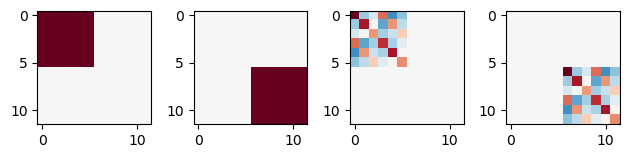

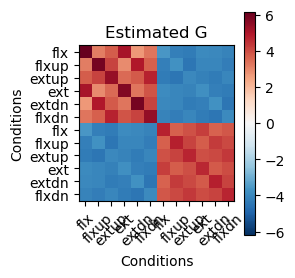

In [2]:
region = 'M1'
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn', 'flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
signal = [5]
nsim = 100
ncond = 12
num_items = 6
rng = np.random.default_rng(seed=3)

file_path = os.path.join(analysisDir, f'pcm_Ghat_best_within_model_{region}.npz')
data = np.load(file_path)
G_mdl = data['G_hat']
G_mdl = G_mdl / np.trace(G_mdl)
# G_mdl = np.eye(6) / 6
C = G_mdl
within_cov = C.reshape(1,num_items,num_items)
Mtrue = pcm.CorrelationModel('corr', num_items=num_items, corr=1, cond_effect=True, within_cov=within_cov)

# visualize the true G:
H = Mtrue.n_param
for i in range(H):
    plt.subplot(1, H, i+1)
    vmin = -np.max(np.abs(Mtrue.Gc[i,:,:]))
    vmax = np.max(np.abs(Mtrue.Gc[i,:,:]))
    plt.imshow(Mtrue.Gc[i,:,:], vmin=vmin, vmax=vmax, cmap='RdBu_r')
    
plt.tight_layout()
plt.show()

cond_vec, part_vec = pcm.sim.make_design(n_cond=12, n_part=10)
D = pcm.sim.make_dataset(model=Mtrue, \
    theta=[0.7,0.4,0.6,-0.5],
    cond_vec=cond_vec,
    part_vec=part_vec,
    n_sim=nsim,
    n_channel=300,
    signal=signal)

# data g matrix:
N = len(D)
G_hat = np.zeros((N, ncond, ncond))
Dist = np.zeros((N,ncond,ncond))
for i in range(N):
    G_hat[i, :, :], _ = pcm.est_G_crossval(D[i].measurements,
                                            D[i].obs_descriptors['cond_vec'],
                                            D[i].obs_descriptors['part_vec'],
                                            X=pcm.matrix.indicator(D[i].obs_descriptors['part_vec']))
    Dist[i,:,:] = pcm.G_to_dist(G_hat[i,:,:])

# visualize the estimated G:
G_mean = np.mean(G_hat, axis=0)
plt.figure(figsize=(3,3))
vmin = -np.max(np.abs(G_mean))
vmax = np.max(np.abs(G_mean))
plt.imshow(G_mean, cmap='RdBu_r', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Estimated G')
plt.xlabel('Conditions')
plt.ylabel('Conditions')
plt.xticks(ticks=np.arange(ncond), labels=labels, rotation=45)
plt.yticks(ticks=np.arange(ncond), labels=labels)
plt.tight_layout()
plt.show()





## make models

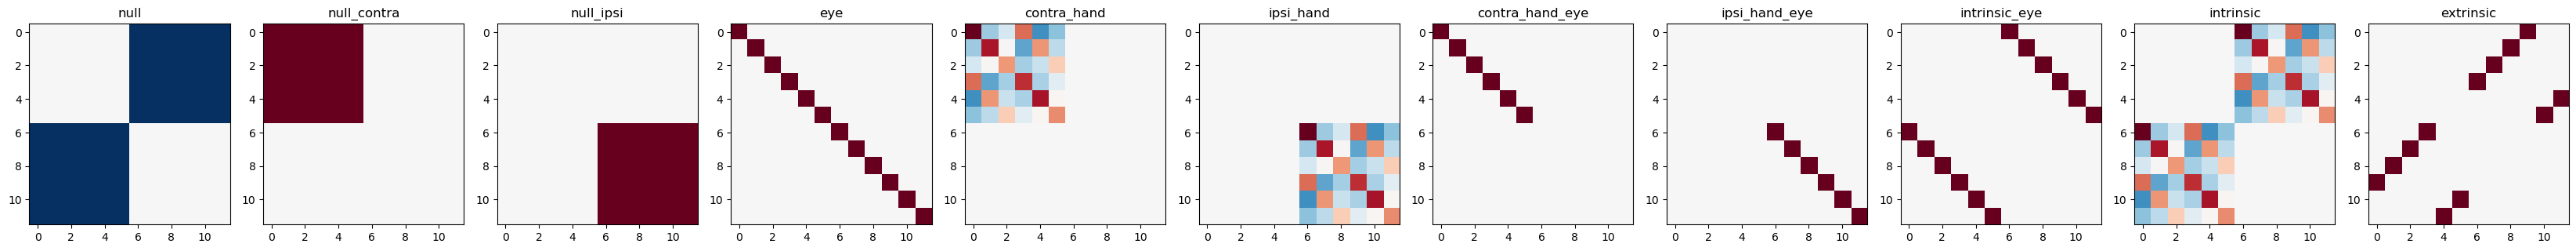

In [3]:
# hand model:
M = []
modelG = {}
ncond = 12

# Null model
# cov = np.zeros((ncond, ncond))
# M.append(pcm.FixedModel('null', cov))

# Simple hand model:
cov = np.zeros((ncond, ncond))
cov[0:6, 6:12] = -1/12
cov[6:12, 0:6] = -1/12
# cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
# cov = cov / np.trace(cov)
modelG['null'] = [cov]
# M.append(pcm.FixedModel('null_contra', cov))

cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = 1
# cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
cov = cov / np.trace(cov)
modelG['null_contra'] = [cov]
# M.append(pcm.FixedModel('null_contra', cov))

cov = np.zeros((ncond, ncond))
cov[6:12, 6:12] = 1
# cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
cov = cov / np.trace(cov)
modelG['null_ipsi'] = [cov]
# M.append(pcm.FixedModel('null_ipsi', cov))

# independent:
cov = np.eye(ncond) / ncond
modelG['eye'] = [cov]
# M.append(pcm.FixedModel('eye', cov))

# Best model from unimanual direction encoding:
file_path = os.path.join(analysisDir, f'pcm_Ghat_best_within_model_{region}.npz')
data = np.load(file_path)
G_mdl = data['G_hat']
G_mdl = G_mdl / np.trace(G_mdl)

G_eye = np.eye(6)

# contra hand structure:
cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = G_mdl
# M.append(pcm.FixedModel('contra hand', cov))
modelG['contra_hand'] = [cov]

# Ipsi hand structure:
cov = np.zeros((ncond, ncond))
cov[6:12, 6:12] = G_mdl
# M.append(pcm.FixedModel('ipsi hand', cov))
modelG['ipsi_hand'] = [cov]

cov = np.zeros((ncond, ncond))
cov[0:6, 0:6] = G_eye
# M.append(pcm.FixedModel('contra hand', cov))
modelG['contra_hand_eye'] = [cov]

# Ipsi hand structure:
cov = np.zeros((ncond, ncond))
cov[6:12, 6:12] = G_eye
# M.append(pcm.FixedModel('ipsi hand', cov))
modelG['ipsi_hand_eye'] = [cov]

# intrinsic contra-ipsi relationship:
cov = np.zeros((ncond, ncond))
cov[0:6, 6:12] = np.eye(6)
cov[6:12, 0:6] = np.eye(6)
# cov = cov / np.trace(cov)
modelG['intrinsic_eye'] = [cov]

# intrinsic contra-ipsi relationship:
cov = np.zeros((ncond, ncond))
cov[0:6, 6:12] = G_mdl
cov[6:12, 0:6] = G_mdl
# cov = cov / np.trace(cov)
modelG['intrinsic'] = [cov]

# extrinsic contra-ipsi relationship:
mask_extrinsic = np.zeros((6,6)) # picking the extrinsicly similar conditions (moving to the same direction in space): e.g., flxup:extup, extdn:flxdn, ...
mask_extrinsic[0,3] = 1
mask_extrinsic[3,0] = 1
mask_extrinsic[1,2] = 1
mask_extrinsic[2,1] = 1
mask_extrinsic[4,5] = 1
mask_extrinsic[5,4] = 1
cov = np.zeros((ncond, ncond))
cov[0:6, 6:12] = mask_extrinsic
cov[6:12, 0:6] = mask_extrinsic
# cov = cov / np.trace(cov)
modelG['extrinsic'] = [cov]

# visualize model G matrices:
H = len(modelG)
plt.figure(figsize=(3*H,3))
for i, key in enumerate(modelG.keys()):
    plt.subplot(1, H, i+1)
    vmin = -np.max(np.abs(modelG[key][0]))
    vmax = np.max(np.abs(modelG[key][0]))
    plt.imshow(modelG[key][0], vmin=vmin, vmax=vmax, cmap='RdBu_r')
    plt.title(key)
plt.tight_layout()
plt.show()

# component models:
M.append(pcm.ComponentModel('data_orthogonal', [modelG['null'][0],modelG['null_contra'][0], modelG['null_ipsi'][0], modelG['contra_hand'][0], modelG['ipsi_hand'][0]]))
M.append(pcm.ComponentModel('eye_orthogonal', [modelG['null'][0],modelG['null_contra'][0],modelG['null_ipsi'][0],modelG['contra_hand_eye'][0], modelG['ipsi_hand_eye'][0]]))
M.append(pcm.ComponentModel('intrinsic_eye', [modelG['null'][0],modelG['null_contra'][0],modelG['null_ipsi'][0],modelG['contra_hand_eye'][0], modelG['ipsi_hand_eye'][0], modelG['intrinsic_eye'][0]]))
M.append(pcm.ComponentModel('intrinsic_data', [modelG['null'][0],modelG['null_contra'][0], modelG['null_ipsi'][0], modelG['contra_hand'][0], modelG['ipsi_hand'][0], modelG['intrinsic'][0]]))
M.append(pcm.ComponentModel('extrinsic_eye', [modelG['null'][0],modelG['null_contra'][0],modelG['null_ipsi'][0],modelG['contra_hand_eye'][0], modelG['ipsi_hand_eye'][0], modelG['extrinsic'][0]]))





## fit model

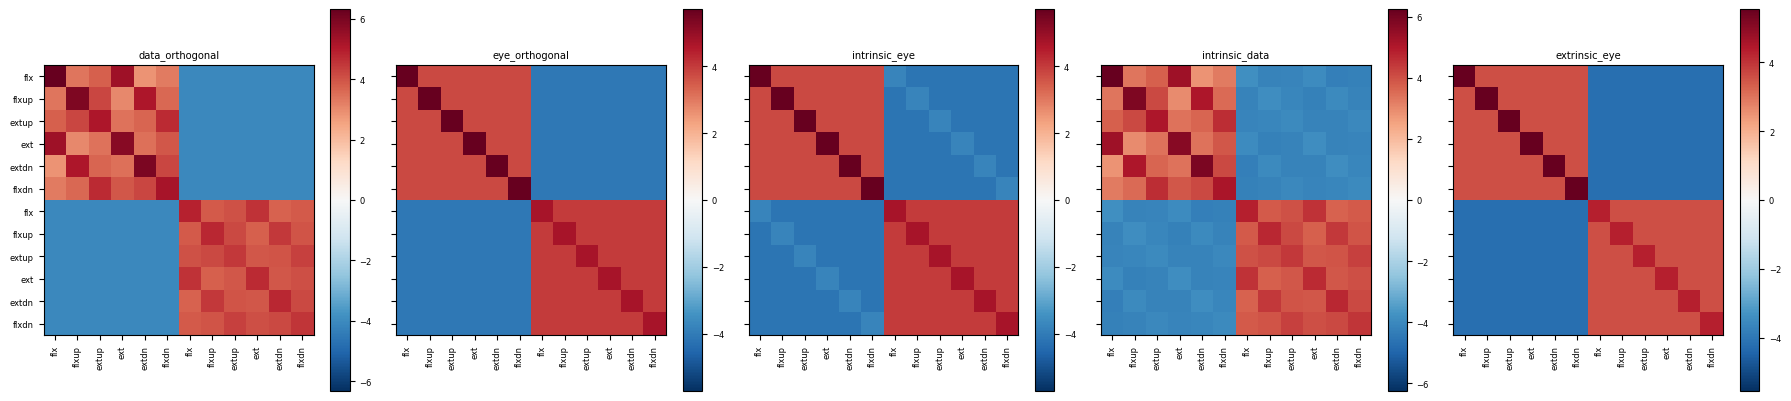

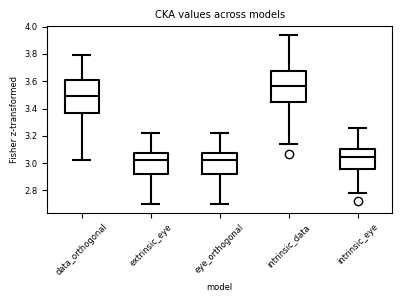

t-test: t=18.782, p=0.000
[3.89448196 3.20445581 3.20520336 2.21747753 1.13320979 0.1734978 ]


variable             CKA                                              \
model    data_orthogonal eye_orthogonal intrinsic_eye intrinsic_data   
0               0.997017       0.994382      0.994618       0.997222   
1               0.998084       0.995421      0.995724       0.998338   
2               0.998441       0.996635      0.996832       0.998547   
3               0.998089       0.995313      0.995586       0.998334   
4               0.998339       0.994943      0.995214       0.998602   
..                   ...            ...           ...            ...   
95              0.998211       0.995467      0.995718       0.998416   
96              0.998986       0.996054      0.996318       0.999228   
97              0.998140       0.996046      0.996255       0.998267   
98              0.998473       0.995258      0.995518       0.998617   
99              0.998259       0.995065      0.995341       0.998512   

variable                    iterations                               \
model    extrinsic_eye data_orthogonal eye_orthogonal intrinsic_eye   
0             0.994382            74.0           91.0         113.0   
1             0.995421            75.0           94.0         107.0   
2             0.996635            73.0           98.0         122.0   
3             0.995313            84.0           89.0         115.0   
4             0.994943            77.0           90.0         122.0   
..                 ...             ...            ...           ...   
95            0.995467            77.0           94.0         116.0   
96            0.996054            87.0           99.0         119.0   
97            0.996046            76.0           95.0         125.0   
98            0.995258            85.0           93.0         112.0   
99            0.995065            77.0           88.0         108.0   

variable                               
model    intrinsic_data extrinsic_eye  
0                  77.0         296.0  
1                  81.0         559.0  
2                  99.0         781.0  
3                  80.0         773.0  
4                  81.0         769.0  
..                  ...           ...  
95                 75.0         748.0  
96                 85.0         312.0  
97                 95.0         533.0  
98                 97.0         338.0  
99                 90.0         740.0  

[100 rows x 10 columns]

In [4]:
T, theta = fit_CKA_individ(D, M, fixed_effect='block', theta0=None, verbose = False)
# print(theta)

nmodels = len(M)
# set font:
matplotlib.rcParams.update({'font.size': 6})
# Plot model predictions:
fig, ax = plt.subplots(1, nmodels, figsize=(18,4), sharey=True)
for i in range(nmodels):
    th = np.mean(theta[i], axis=1)
    G = M[i].predict(th[:M[i].n_param])[0]
    vmin = -np.max(np.abs(G))
    vmax = np.max(np.abs(G))
    ax[i].imshow(G, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(12)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(12)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(G, cmap='RdBu_r', vmin=vmin, vmax=vmax), ax=ax[i])
plt.tight_layout()
plt.show()

# Convert MultiIndex columns to long form
# Stack the *model* level, so models become rows
T_long = (
    T.stack(level='model')        # move model into the index
      .reset_index()              # index -> columns
      .melt(id_vars=['level_0', 'model'],
            var_name='metric',
            value_name='value')
)
T_long

# boxplot CKA:
T_cka = T_long[T_long['metric'] == 'CKA']
T_cka['value'] = np.arctanh(T_cka['value'])  # Fisher z-transform
plt.figure(figsize=(4,3))
sns.boxplot(data=T_cka, x='model', y='value', color='k', fill=False, width=0.5)
plt.xticks(rotation=45)
plt.title('CKA values across models')
plt.ylabel('Fisher z-transformed')
plt.tight_layout()
plt.show()


# ttest between intrinsic_data vs data_orthogonal:
from scipy.stats import ttest_rel
data_intrinsic = T_cka[T_cka['model'] == 'intrinsic_data']['value'].values
data_orthogonal = T_cka[T_cka['model'] == 'data_orthogonal']['value'].values
t_stat, p_val = ttest_rel(data_intrinsic, data_orthogonal, alternative='greater')
print(f't-test: t={t_stat:.3f}, p={p_val:.3f}')

print(np.mean(theta[3],axis=1))

T



# analytical vs empirical

Empirical Gradient: [-0.02566317 -0.04374099  0.14835411  0.03356119 -0.0077211  -0.07549823
  0.08902583  0.22438228 -0.09588709  0.12900704]
Analytical Gradient: [-0.02566317 -0.04374099  0.14835411  0.03356119 -0.0077211  -0.07549823
  0.08902583  0.22438228 -0.09588709  0.12900704]
Difference: 1.5421277723349408e-10


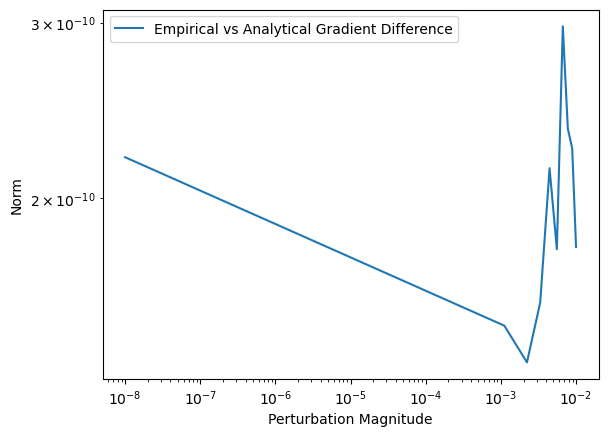

In [7]:
def CKA(a,b):
    cka = (a.T @ b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cka

def grad_empirical(a, b, h=1e-6):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    if a.shape != b.shape:
        raise ValueError("a and b must have the same shape")
    grad = np.zeros_like(b, dtype=float)
    for i in range(b.size):
        ei = np.zeros_like(b)
        ei[i] = 1.0
        sp = CKA(a, b + h*ei)
        sm = CKA(a, b - h*ei)
        grad[i] = (sp - sm) / (2*h)
    return grad

def grad_analytical(a, b, h=1e-6):
    return a/(np.linalg.norm(a) * np.linalg.norm(b)) - (CKA(a,b) * b) / (np.linalg.norm(b)**2)

# compare empirical and analytical gradients:
a = np.random.rand(10)
b = np.random.rand(10)
grad_emp = grad_empirical(a, b)
grad_ana = grad_analytical(a, b)
print("Empirical Gradient:", grad_emp)
print("Analytical Gradient:", grad_ana)
print("Difference:", np.linalg.norm(grad_emp - grad_ana))

# plot both gradients for different differences:
diffs = np.linspace(1e-8, 1e-2, 10)
emp_diffs = []
ana_diffs = []
for d in diffs:
    b_perturbed = b + d * np.random.randn(*b.shape)
    grad_emp = grad_empirical(a, b_perturbed)
    grad_ana = grad_analytical(a, b_perturbed)
    emp_diffs.append(np.linalg.norm(grad_emp - grad_ana))
plt.loglog(diffs, emp_diffs, label='Empirical vs Analytical Gradient Difference')
plt.xlabel('Perturbation Magnitude')
plt.ylabel('Norm')
plt.legend()
plt.show()


